In [46]:
import signalfloweeg 
import mne 

filepath = "/home/cbl/Desktop/Test_Data/0012_rest.set"
EEG = mne.io.read_raw_eeglab(filepath)
filtered_eeg = signalfloweeg.preprocessing.filtering.bandpass_filter(EEG, 2, 50)
filtered_eeg = signalfloweeg.preprocessing.filtering.notch_filter(filtered_eeg, 60)
filtered_eeg = signalfloweeg.preprocessing.resampling.resample(filtered_eeg, 500)
epochs = signalfloweeg.preprocessing.epoching.epoch_time(filtered_eeg, 1)

signalfloweeg.viz.heatmap.heatmap(epochs)

# # Access the segmented data
# data = epochs.get_data()
# print(data.shape)  # Shape of the segmented data

# # Plot the epochs
# epochs.plot(block=True)


Reading /home/cbl/Desktop/Test_Data/0012_rest.fdt
Reading 0 ... 307139  =      0.000 ...   307.139 secs...


/home/cbl/mne-python/1.7.0_0/lib/python3.12/site-packages/pymatreader/utils.py:238: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 58 - 62 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 58.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 57.75 Hz)
- Upper passband edge: 62.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 62.25 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s


Not setting metadata
307 matching events found
No baseline correction applied
0 projection items activated
None


In [45]:
signalfloweeg.viz.heatmap(epochs)

None


In [17]:
from fooof import FOOOF
from fooof.utils import trim_spectrum
from fooof.sim.gen import gen_aperiodic
import numpy as np
import matplotlib.pyplot as plt

Using data from preloaded Raw for 307 events and 500 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


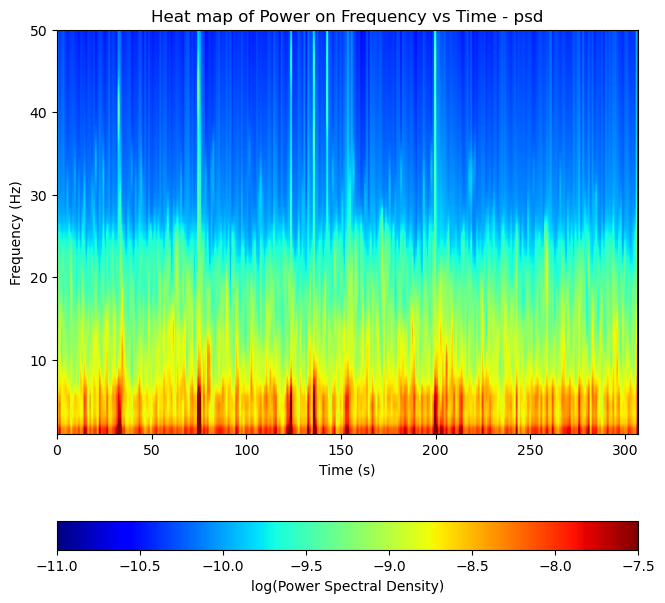

In [33]:
temp = epochs.compute_psd()
FOOF_List = list()
periodic_list = list()
for i in range(0, temp.data.shape[0]):
    freqs = temp.freqs
    psd = temp.data[i]
    avgpow = np.mean(psd, axis=0)
    freqs_ext, pow_ext = trim_spectrum(freqs, avgpow, [0.5,50])
    fm = FOOOF(
                peak_width_limits = [2,5], 
                max_n_peaks = 5,
            )
    fm.fit(freqs_ext, pow_ext)
    FOOF_List.append(fm)

epochs = len(FOOF_List)
freqs = FOOF_List[0].freqs
for k in range(0, len(FOOF_List)):
    fm = FOOF_List[k]
    periodic = fm.fooofed_spectrum_
    aperiodic = gen_aperiodic(fm.freqs, fm._robust_ap_fit(fm.freqs, fm.power_spectrum))
    # riemanAreaVals = riemanArea(aperiodic,fm)
    # FOOOFpsd(fm.freqs,periodic,i, init_ap_fit)
    periodic_list.append(periodic)
    # area_list.append(riemanAreaVals)

periodic_array = np.array(periodic_list)
periodic_array = periodic_array.T
    # area_array = np.array(area_list)
    # area_array = area_array.T

#Plot settings for power heat map
plt.figure(figsize=(7.5,7.5))
plt.imshow(periodic_array, cmap='jet', origin='lower', extent=[0,1*epochs,freqs.min(),freqs.max()], aspect='auto')
plt.colorbar(label="log(Power Spectral Density)", location='bottom', orientation='horizontal')
plt.title("Heat map of Power on Frequency vs Time - " + "psd")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()